First import all neccessary modules

In [96]:
from datetime import datetime
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras.metrics import Accuracy, Precision, Recall
from keras.optimizers import Adam, RMSprop, SGD, Nadam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import keras
from positional_encoding import PositionalEncoding

from preprocessor import Preprocessor
from message_encoder import *

Next we define all hyperparameters for the Training of the LSTM module. 

In [97]:
# === Preprocessing parameters ===
log_files = [i for i in range(745, 754)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # int, how many datapoints per class should be collected if available
window_size = 20                                    # int, how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # int, dimensionality of each message's encoded vector representation
message_encoder = BERTEncoder(encoding_output_size) # encoder object, can be TextVectorizationEncoder, BERTEncoder, or BERTEmbeddingEncoder
extended_datetime_features = False                  # bool, whether to use additional normalized datetime features
preprocessor_file = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"  # str (path), if not empty and exists, loads existing preprocessor file instead of creating one

Next we load logs and preprocess the data. 

In [ ]:
# === Load or preprocess data ===
if os.path.isfile(preprocessor_file):
    print("loading preprocessor from file")
    pp = Preprocessor.load(preprocessor_file)
else:
    pp = Preprocessor(log_files, message_encoder,
                      logs_per_class=logs_per_class,
                      window_size=window_size,
                      extended_datetime_features=extended_datetime_features,
                      volatile=True)
    pp.preprocess()
    path = f"./data/preprocessors/preprocessor_{len(pp.loaded_files)}files_"
    enc_type = "BERTenc" if isinstance(pp.message_encoder, BERTEncoder) else "BERTemb" if isinstance(pp.message_encoder, BERTEmbeddingEncoder) else "TextVec"
    path += f"{logs_per_class}lpc_{window_size}ws_{enc_type}x{encoding_output_size}"
    if extended_datetime_features:
        path += "_extdt"
    path += ".json"
    if not os.path.isfile(path):
        pp.save(path)


/home/a_gerw500/agmge/log-classification/venv/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Define the model architecture for the Transformer, then train the Transformer model. 

In [151]:
# === Transformer Hyperparameters ===
model_dim = 128                                     # int, dimension of the transformer hidden layers; must be divisible by num_heads
num_heads = 4                                       # int, number of attention heads in multi-head attention; must divide model_dim evenly
ff_dim = 256                                        # int, dimension of the feed-forward layer inside each transformer block
num_transformer_blocks = 2                          # int, how many stacked transformer blocks to use; generally 1–6 for lightweight models
dropout_rate = 0                                  # float in range [0.0, 1.0], dropout rate for regularization; 0.0 disables dropout


# === Training hyperparameters ===
split_ratios = (9, 1)                               # tuple of ints, ratio of data split for training and testing
epochs = 1000                                       # int, number of iterations (epochs) to train the model
batch_size = 32                                     # int, number of samples per training batch
early_stopping_monitor = "val_loss"                 # str, metric to monitor for early stopping; options: 'loss', 'val_loss', 'accuracy', 'val_accuracy', etc.
early_stopping_patience = 10                        # int, number of epochs with no improvement after which training will be stopped
early_stopping_restore_best = True                  # bool, whether to restore model weights from the epoch with the best monitored value
validation_split = 0.1                              # float in range (0.0, 1.0), fraction of training data to reserve for validation
learning_rate = 0.001                               # float > 0.0, learning rate used by the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer instance, can be Adam, RMSprop, SGD (optionally with momentum), or Nadam


In [152]:
# === Prepare data ===
train, test = pp.data.stratified_split(split_ratios)
X_train, y_train = train
X_test, y_test = test
input_shape = pp.data.entry_shape
num_classes = len(set(y_train))

In [153]:
# === Transformer Block ===
def transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim // num_heads)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(model_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

# === Build Transformer Model ===
inputs = Input(shape=input_shape)
x = Dense(model_dim)(inputs)  # Project to model dimension
x = PositionalEncoding()(x)

# Apply multiple transformer blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate)

x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stopping = EarlyStopping(monitor=early_stopping_monitor,
                               patience=early_stopping_patience,
                               restore_best_weights=early_stopping_restore_best)

model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=validation_split,
          callbacks=[early_stopping],
          verbose=0)

2025-06-19 14:17:27.194825: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 128 bytes spill stores, 128 bytes spill loads

2025-06-19 14:17:27.337304: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1861', 8 bytes spill stores, 8 bytes spill loads

2025-06-19 14:17:27.490337: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_56', 416 bytes spill stores, 352 bytes spill loads

2025-06-19 14:17:27.590031: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_58', 416 bytes spill stores, 352 bytes spill loads

2025-06-19 14:17:28.135252: I external/lo

Optionally save the weights of the model

In [154]:
# === Save model ===
filename = f"../models/transformer_{num_transformer_blocks}x{model_dim}_heads{num_heads}_ffdim{ff_dim}_drop{dropout_rate}_lr{learning_rate}_bs{batch_size}_ep{epochs}_earlystp{early_stopping_monitor}{early_stopping_patience}{early_stopping_restore_best}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
model.save(f"{filename}.keras")

Evaluate model and print scores

2025-06-19 14:17:37.647026: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8_0', 128 bytes spill stores, 128 bytes spill loads

2025-06-19 14:17:37.744727: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18', 428 bytes spill stores, 340 bytes spill loads

2025-06-19 14:17:38.006401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20', 428 bytes spill stores, 340 bytes spill loads

2025-06-19 14:17:38.016969: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 8 bytes spill stores, 8 bytes spill loads

2025-06-19 14:17:38.164753: I external/loc

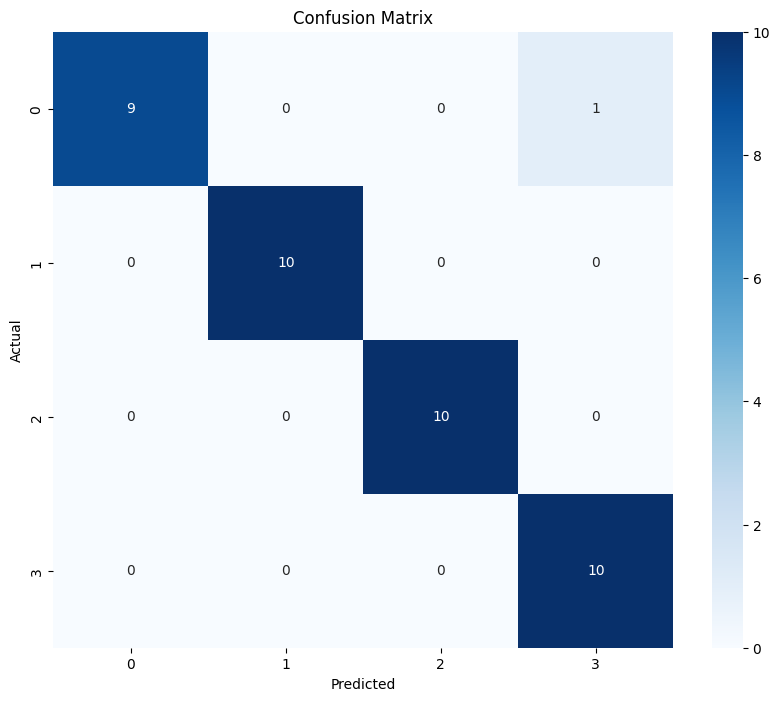

In [155]:
f = open(f"{filename}.txt", "w")
ostd = sys.stdout
sys.stdout = f


# === Evaluate ===
model.summary(print_fn=f.write)
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# === Predictions & Report ===
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"{filename}.png")
plt.show()

# === Preview Predictions ===
for i in range(min(80, len(y_pred))):
    print(f"True: {y_test[i]}, Pred: {y_pred[i]}, Prob: {predictions[i]}")





sys.stdout = ostd
f.close()

Save the confusion matrix